# Model creation
This Notebook shows creation of Toxic Comment model, for 6 labels.

In [23]:
import pandas as pd
import numpy as np

import torch
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from tqdm import trange

from torch.optim import RMSprop


%load_ext autoreload
%autoreload 2
from help_tool import help_tool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070 Ti'

In [25]:
df = pd.read_csv(r'Archive\clean_data.csv').drop(columns='Unnamed: 0')

In [26]:
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Labels are passed in to model as list of One-Hot-Encoded classes

In [27]:
df = df.sample(frac=1).reset_index(drop=True)
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,a5896e0a6ad600e4,fringe theory article currently contains sente...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,1afa52bfba7feca0,yes faggot bitch ass motherfucker yes faggot b...,1,1,1,0,0,0,"[1, 1, 1, 0, 0, 0]"
2,7a1754976340df7d,know listed english level worry seem nicely ot...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,1e5f7227a2c03070,see talk page zyxoas see talk page ubuntu page...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,c42e063caf56583a,ive made comments article talk page ironically...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


Data has 157k rows, but for half of it (70k) will be used. This is for speed.

In [28]:
df.shape

(157572, 9)

In [29]:
df = df.sample(70000, random_state=42).reset_index()

In [30]:
labels = list(df.one_hot_labels.values)
comments = list(df.comment_text.values)

EDA part showed, that most word counts don't pass 100 lenght, thus maxx length is 100.

In [31]:
max_length = 100
tokenizer = RobertaTokenizer.from_pretrained(
    'roberta-base', do_lower_case=False)
encodings = tokenizer.batch_encode_plus(
    comments, max_length=max_length, padding=True, truncation=True)

print('tokenizer outputs: ', encodings.keys())

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [32]:
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

Dropping Rare Classes with very rare combinations of labels (e.g., those that appear less than twice). This ensures that train_test_split can stratify properly.

In [33]:
label_counts = df['one_hot_labels'].astype(str).value_counts()
one_freq = label_counts[label_counts == 1].keys()
one_freq_idxs = sorted(
    list(df[df['one_hot_labels'].astype(str).isin(one_freq)].index), reverse=True)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]


print(len(input_ids))
print(len(labels))
print(len(attention_masks))

69994
69994
69994


severe_toxic, threat, identity_hate are below 1% of cases, these classes might not result in good predictions.

In [34]:
df[['toxic', 'severe_toxic', 'obscene',
    'threat', 'insult', 'identity_hate']].sum() / df.shape[0] * 100

toxic            9.560000
severe_toxic     0.967143
obscene          5.301429
threat           0.300000
insult           4.915714
identity_hate    0.862857
dtype: float64

# Dataloaders
## Train, Validation
Train and Validation are split 90/10 with stratification. These sets were cleaned in EDA, for ensuring model learns only relevent information.

In [35]:
batch_size = 32

In [36]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=42, test_size=0.1, stratify=labels
)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

In [37]:
train_dataloader = help_tool.sequential_sampler_dataloader_creation(
    batch_size, train_inputs, train_labels, train_masks)
validation_dataloader = help_tool.sequential_sampler_dataloader_creation(
    batch_size, validation_inputs, validation_labels, validation_masks)

torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [38]:
validation_dataloader = help_tool.sequential_sampler_dataloader_creation(
    batch_size, validation_inputs, validation_labels, validation_masks)

## Test data
Test data is not cleaned, for making sure model can perform in real life settings.

In [39]:
test_df = pd.read_csv('Archive/test.csv')
test_labels_df = pd.read_csv('Archive/test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any())
print('Same columns between train and test: ', label_cols ==
      test_label_cols)  

test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)]
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

Null values:  False
Same columns between train and test:  True


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


Test data is cleaned the same way Training and Validation data was cleaned

In [49]:
def cleaning_comments(df):
    # Removing the part of the string that matches the pattern
    df['comment_text'] = df['comment_text'].str.replace(
        r"\(talk.*?\)", "", regex=True)
    df['comment_text'] = df['comment_text'].str.replace(
        r"\(UTC.*?\)", "", regex=True)
    df['comment_text'] = df['comment_text'].apply(
        help_tool.replace_url_with_domain)

    combined_pattern = (
        r'\b(?:\d{1,2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31, 19 July 2006"
        r'\d{1,2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 19 July 2006"
        r'\d{1,2} [A-Za-z]{3,10}, \d{4}|'  # "31 July, 2006"
        r'\d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 July 2006"
        # "31, July 2006, 18:47"
        r'\d{1,2}, [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'
        # "31 July 2006, 18:47"
        r'\d{1,2} [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'
        r'\d{1,2} [A-Za-z]{3,10} \d{4} \d{1,2}:\d{2}|'  # "31 July 2006 18:47"
        # "18:47, July 31, 2006"
        r'\d{1,2}:\d{2}, [A-Za-z]{3,10} \d{1,2}, \d{4}|'
        # "18:47, 31 July 2006"
        r'\d{1,2}:\d{2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'
        r'\d{1,2}:\d{2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47 31 July 2006"
        r'\d{1,2} [A-Za-z]{3,10} \d{1,2}:\d{2}|'  # "26 July 17:03 UTC"
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'  # IP address
        r')\b'
    )

    # Remove the date pattern from the 'comment_text' column
    df['comment_text'] = df['comment_text'].str.replace(
        combined_pattern, '', regex=True).str.strip()
    df['comment_text'] = df['comment_text'].apply(
        help_tool.expand_contractions)

    df['comment_text'] = df['comment_text'].replace(
        {'Wikipedia:': '', 'WP:': '', 'Category:': '', 'disambiguation': '', 'otheruses': ''
         })
    df = df[~ df['comment_text'].str.contains("Navbox")]
    df['comment_text'] = df['comment_text'].apply(help_tool.replace_filenames)
    df['comment_text'] = df['comment_text'].apply(help_tool.clean_text)
    df['comment_text'] = df['comment_text'].apply(help_tool.remove_stopwords)
    df['comment_text'] = df['comment_text'].apply(help_tool.remove_non_ascii)
    df = df[~df['comment_text'].duplicated()]

    return df


test_df = cleaning_comments(test_df)

C:\Users\User\AppData\Local\Temp\ipykernel_15156\1219710184.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text'] = df['comment_text'].apply(help_tool.replace_filenames)
C:\Users\User\AppData\Local\Temp\ipykernel_15156\1219710184.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text'] = df['comment_text'].apply(help_tool.clean_text)
C:\Users\User\AppData\Local\Temp\ipykernel_15156\1219710184.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [50]:
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.comment_text.values)


test_encodings = tokenizer.batch_encode_plus(
    test_comments, max_length=max_length, padding=True, truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

test_dataloader = help_tool.sequential_sampler_dataloader_creation(
    batch_size, test_input_ids, test_labels, test_attention_masks)

torch.save(test_dataloader, 'test_data_loader')

# Roberta Model and parameters
RoBERTa (Robustly Optimized BERT Pretraining Approach) for toxic comment classification was choosen for:
* Contextual Understanding: RoBERTa, being a transformer-based model.
* Pretraining: RoBERTa is pretrained on a large corpus with more data and for a longer time than BERT, giving it a better ability to handle complex language.
* Transfer Learning.

In [41]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=num_labels)
model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [42]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Sigmoid Activation Function with RM Stop Optimizer
## Training
Model will be used for transfer learning. Key aspects of model:
* BCEWithLogitsLoss (Binary Cross Entropy with Logits Loss)
* Sigmoid Activation
* RMSprop Optimizer


In [43]:
optimizer = RMSprop(optimizer_grouped_parameters, lr=2e-5,
                    alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)

In [44]:
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}

epochs = 3

for epoch in trange(epochs, desc="Epoch"):

    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)
    per_class_train_correct = np.zeros(num_labels)
    per_class_train_total = np.zeros(num_labels)

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
        logits = outputs[0]

        loss_func = BCEWithLogitsLoss()
        loss = loss_func(logits.view(-1, num_labels),
                         b_labels.type_as(logits).view(-1, num_labels))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        for i in range(num_labels):
            per_class_train_loss[i] += loss_func(
                logits[:, i], b_labels[:, i].type_as(logits)).item()

            pred_bools_per_class = (
                pred_labels_train[:, i] > 0.5).cpu().numpy()
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)

            per_class_train_correct[i] += np.sum(
                pred_bools_per_class == true_bools_per_class)
            per_class_train_total[i] += len(true_bools_per_class)

    for i in range(num_labels):
        train_loss_per_class[i].append(
            per_class_train_loss[i] / len(train_dataloader))
        train_accuracy_per_class[i].append(
            100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    flat_pred_labels_train = [
        item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [
        item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_loss = np.zeros(num_labels)
    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            loss_func = BCEWithLogitsLoss()
            loss = loss_func(logits.view(-1, num_labels),
                             b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            # Per-class loss and accuracy tracking
            for i in range(num_labels):
                per_class_val_loss[i] += loss_func(
                    logits[:, i], b_labels[:, i].type_as(logits)).item()

                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()
                true_bools_per_class = (
                    b_labels[:, i].detach().cpu().numpy() == 1)

                per_class_val_correct[i] += np.sum(
                    pred_bools_per_class == true_bools_per_class)
                per_class_val_total[i] += len(true_bools_per_class)

    # Average training loss and accuracy for each class
    for i in range(num_labels):
        val_loss_per_class[i].append(
            per_class_val_loss[i] / len(validation_dataloader))
        val_accuracy_per_class[i].append(
            100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch:  33%|███▎      | 1/3 [14:22<28:44, 862.04s/it]

Epoch 1 - Training Loss: 0.0949, Training Accuracy: 90.15%, Validation Loss: 0.0709, Validation Accuracy: 91.21%


Epoch:  67%|██████▋   | 2/3 [28:30<14:13, 853.94s/it]

Epoch 2 - Training Loss: 0.0824, Training Accuracy: 90.57%, Validation Loss: 0.0678, Validation Accuracy: 91.57%


Epoch: 100%|██████████| 3/3 [42:50<00:00, 856.95s/it]

Epoch 3 - Training Loss: 0.0798, Training Accuracy: 90.64%, Validation Loss: 0.0753, Validation Accuracy: 89.54%


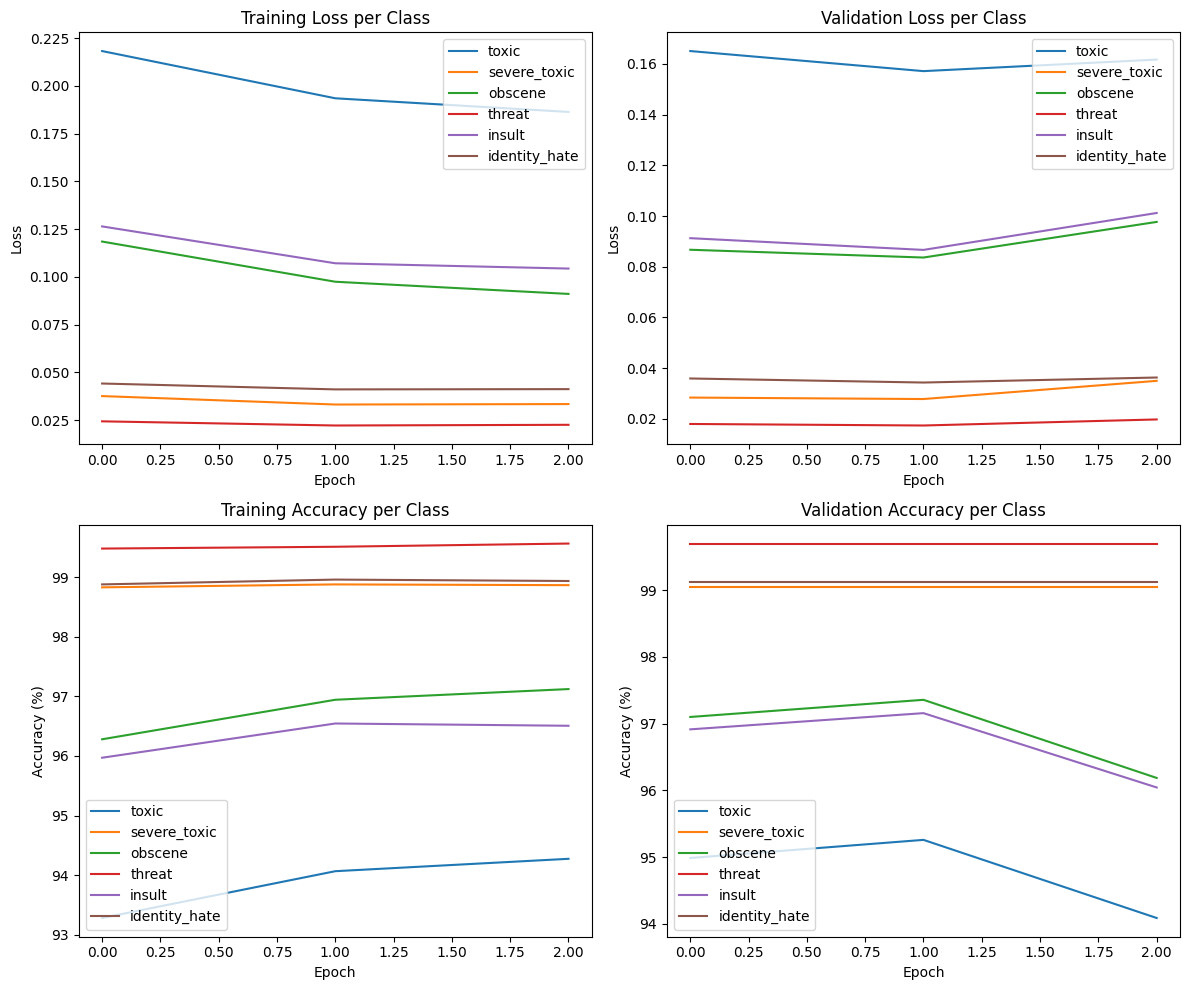

In [45]:
help_tool.plot_per_class(train_loss_per_class, val_loss_per_class,
                         train_accuracy_per_class, val_accuracy_per_class)

In [46]:
torch.save(model.state_dict(), 'model_RMSprop_per_class')

Highest accuracy and lowest Loss is seen in:
* Threat
* Identity hate  
* Severe Toxic

But these correspond to lowest numbers of cases in available data. Model is not predicting these classes at all.

## Optimizing threshold value for F1 score 
Thershold optimization uses sklearn classification_report in help_tool. Looking deaper into F1 - the 3 classes have no predictions or very low predictions. Despite classes being not predicted, 
* Toxic
* Obscene
* Insult

Have each about 70% F1 score, which is good. 
* Threshold for Sigmoid activation - 0.71

In [47]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(
    model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.71
F1:  0.68
Accuracy:  0.91 

               precision    recall  f1-score   support

        toxic       0.83      0.62      0.71       669
 severe_toxic       0.00      0.00      0.00        67
      obscene       0.73      0.74      0.73       371
       threat       0.00      0.00      0.00        21
       insult       0.72      0.68      0.70       345
identity_hate       0.00      0.00      0.00        61

    micro avg       0.77      0.60      0.68      1534
    macro avg       0.38      0.34      0.36      1534
 weighted avg       0.70      0.60      0.64      1534
  samples avg       0.05      0.05      0.05      1534



## Test data
Evaluating data on never-seen Test dataset - all scores decreased (as expected). F1 score shows around 60% for classes with predictions. This shows model is somewhat better than random guessing, but not good.

In [51]:
help_tool.altered_tresshold_classification_report(
    model, device, test_dataloader, test_label_cols, 0.71)

F1:  0.60
Accuracy:  0.89 

               precision    recall  f1-score   support

        toxic       0.60      0.68      0.64      6045
 severe_toxic       0.00      0.00      0.00       365
      obscene       0.58      0.73      0.65      3668
       threat       0.00      0.00      0.00       208
       insult       0.55      0.63      0.59      3411
identity_hate       0.00      0.00      0.00       712

    micro avg       0.58      0.62      0.60     14409
    macro avg       0.29      0.34      0.31     14409
 weighted avg       0.53      0.62      0.57     14409
  samples avg       0.06      0.06      0.05     14409



## Conclusion
RMStop Optimizer was used, for creating Reberta model with 60% F1 score. Categories with higher amounts of cases::
* Toxic
* Obscene
* Insult

got predictions, but the other  3 classes got no predictions. 

# Sigmoid Activation Function with RM Stop Optimizer
## Training
Model will be used for transfer learning. Key aspects of model:
* BCEWithLogitsLoss (Binary Cross Entropy with Logits Loss)
* Sigmoid Activation
* AdamW optimizer, which is well-suited for fine-tuning transformer models.

In [59]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5,
                  correct_bias=True, no_deprecation_warning=True)

In [61]:
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}

epochs = 3

for epoch in trange(epochs, desc="Epoch"):

    # Training
    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)
    per_class_train_correct = np.zeros(num_labels)
    per_class_train_total = np.zeros(num_labels)

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
        logits = outputs[0]

        loss_func = BCEWithLogitsLoss()
        loss = loss_func(logits.view(-1, num_labels),
                         b_labels.type_as(logits).view(-1, num_labels))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        for i in range(num_labels):
            per_class_train_loss[i] += loss_func(
                logits[:, i], b_labels[:, i].type_as(logits)).item()

            pred_bools_per_class = (
                pred_labels_train[:, i] > 0.5).cpu().numpy()
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)

            per_class_train_correct[i] += np.sum(
                pred_bools_per_class == true_bools_per_class)
            per_class_train_total[i] += len(true_bools_per_class)

    # Calculate average training loss and accuracy for each class
    for i in range(num_labels):
        train_loss_per_class[i].append(
            per_class_train_loss[i] / len(train_dataloader))
        train_accuracy_per_class[i].append(
            100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    flat_pred_labels_train = [
        item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [
        item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_loss = np.zeros(num_labels)
    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            loss_func = BCEWithLogitsLoss()
            loss = loss_func(logits.view(-1, num_labels),
                             b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            # Per-class validation loss and accuracy tracking
            for i in range(num_labels):
                per_class_val_loss[i] += loss_func(
                    logits[:, i], b_labels[:, i].type_as(logits)).item()

                # Convert to numpy arrays for proper comparison
                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()
                true_bools_per_class = (
                    b_labels[:, i].detach().cpu().numpy() == 1)

                # Sum correct predictions
                per_class_val_correct[i] += np.sum(
                    pred_bools_per_class == true_bools_per_class)
                per_class_val_total[i] += len(true_bools_per_class)

    for i in range(num_labels):
        val_loss_per_class[i].append(
            per_class_val_loss[i] / len(validation_dataloader))
        val_accuracy_per_class[i].append(
            100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch:  33%|███▎      | 1/3 [13:58<27:56, 838.17s/it]

Epoch 1 - Training Loss: 0.0674, Training Accuracy: 91.17%, Validation Loss: 0.0632, Validation Accuracy: 91.49%


Epoch:  67%|██████▋   | 2/3 [27:57<13:58, 838.78s/it]

Epoch 2 - Training Loss: 0.0608, Training Accuracy: 91.27%, Validation Loss: 0.0622, Validation Accuracy: 91.57%


Epoch: 100%|██████████| 3/3 [41:56<00:00, 838.82s/it]

Epoch 3 - Training Loss: 0.0558, Training Accuracy: 91.44%, Validation Loss: 0.0614, Validation Accuracy: 91.63%


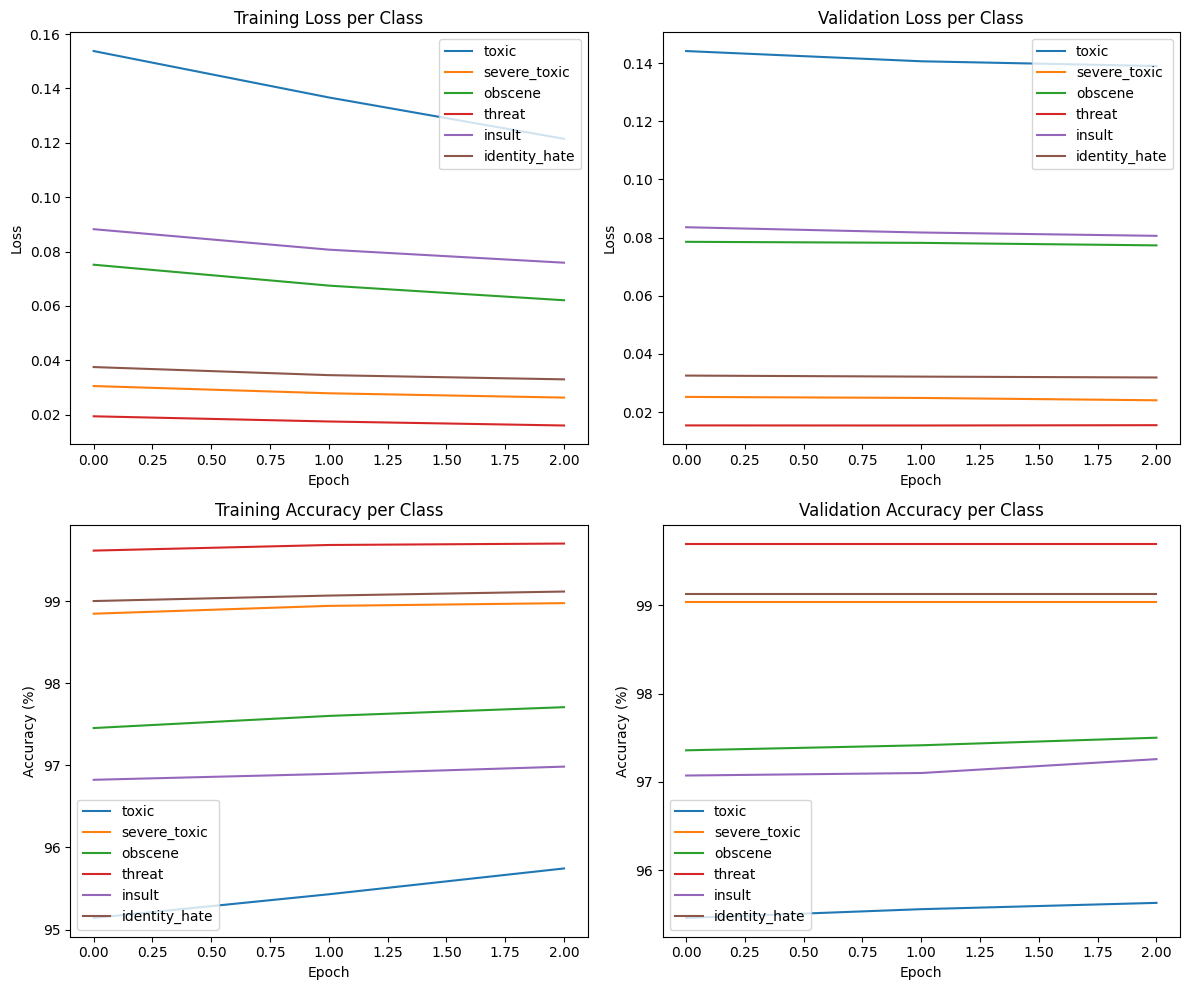

In [62]:
help_tool.plot_per_class(train_loss_per_class, val_loss_per_class,
                         train_accuracy_per_class, val_accuracy_per_class)

Optimizer AdamW shows similar results to RMStop, with similar running time.

In [63]:
torch.save(model.state_dict(), 'model_AdamW_per_class')

## Optimizing threshold value for F1 score 
Threshold optimization for F1 shows similar, but slightly better results to RMStop. Best threshold for AdamW - 0.4

In [64]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(
    model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.40
F1:  0.70
Accuracy:  0.92 

               precision    recall  f1-score   support

        toxic       0.83      0.67      0.74       669
 severe_toxic       0.75      0.13      0.23        67
      obscene       0.74      0.79      0.76       371
       threat       0.00      0.00      0.00        21
       insult       0.68      0.75      0.71       345
identity_hate       0.00      0.00      0.00        61

    micro avg       0.76      0.66      0.70      1534
    macro avg       0.50      0.39      0.41      1534
 weighted avg       0.72      0.66      0.68      1534
  samples avg       0.06      0.06      0.05      1534



## Test data
Never seen data has similar results for large case categories, but also severe_toxic got some predictions.

In [65]:
help_tool.altered_tresshold_classification_report(
    model, device, test_dataloader, test_label_cols, 0.40)

F1:  0.61
Accuracy:  0.88 

               precision    recall  f1-score   support

        toxic       0.57      0.75      0.65      6045
 severe_toxic       0.42      0.18      0.25       365
      obscene       0.56      0.78      0.65      3668
       threat       0.00      0.00      0.00       208
       insult       0.50      0.72      0.59      3411
identity_hate       0.00      0.00      0.00       712

    micro avg       0.55      0.69      0.61     14409
    macro avg       0.34      0.40      0.36     14409
 weighted avg       0.51      0.69      0.58     14409
  samples avg       0.06      0.06      0.06     14409



## Conclusion
AdamW optimizer is more suited for Reberta, than RMStop. As severe_toxic got some predictions.

# Weighted BCE
## Training
Model will be used for transfer learning. Key aspects of model:
* Weighted BCE
* Sigmoid Activation
* AdamW optimizer


In [66]:
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}


def calculate_class_weights(labels):
    positive_samples = labels.sum(axis=0)
    negative_samples = labels.shape[0] - positive_samples
    class_weights = negative_samples / (positive_samples + 1e-5)
    return torch.tensor(class_weights, dtype=torch.float).to(device)


epochs = 3

for epoch in trange(epochs, desc="Epoch"):

    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)
    per_class_train_correct = np.zeros(num_labels)
    per_class_train_total = np.zeros(num_labels)

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
        logits = outputs[0]

        # Class weights for Weighted BCE
        class_weights = calculate_class_weights(b_labels.cpu().numpy())

        loss_func = BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_func(logits.view(-1, num_labels),
                         b_labels.type_as(logits).view(-1, num_labels))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Predictions
        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        # Per-class accuracy tracking
        for i in range(num_labels):
            pred_bools_per_class = (
                pred_labels_train[:, i] > 0.5).cpu().numpy()
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)

            per_class_train_correct[i] += np.sum(
                pred_bools_per_class == true_bools_per_class)
            per_class_train_total[i] += len(true_bools_per_class)

    for i in range(num_labels):
        train_loss_per_class[i].append(
            total_train_loss / len(train_dataloader))
        train_accuracy_per_class[i].append(
            100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    flat_pred_labels_train = [
        item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [
        item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            class_weights = calculate_class_weights(b_labels.cpu().numpy())
            loss_func = BCEWithLogitsLoss(pos_weight=class_weights)
            loss = loss_func(logits.view(-1, num_labels),
                             b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            for i in range(num_labels):
                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()
                true_bools_per_class = (
                    b_labels[:, i].detach().cpu().numpy() == 1)

                per_class_val_correct[i] += np.sum(
                    pred_bools_per_class == true_bools_per_class)
                per_class_val_total[i] += len(true_bools_per_class)

    for i in range(num_labels):
        val_loss_per_class[i].append(
            total_val_loss / len(validation_dataloader))
        val_accuracy_per_class[i].append(
            100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch:  33%|███▎      | 1/3 [14:22<28:45, 862.73s/it]

Epoch 1 - Training Loss: 0.2524, Training Accuracy: 84.11%, Validation Loss: 0.3314, Validation Accuracy: 86.47%


Epoch:  67%|██████▋   | 2/3 [28:21<14:08, 848.67s/it]

Epoch 2 - Training Loss: 0.2106, Training Accuracy: 85.72%, Validation Loss: 0.3694, Validation Accuracy: 87.34%


Epoch: 100%|██████████| 3/3 [42:20<00:00, 846.95s/it]

Epoch 3 - Training Loss: 0.1925, Training Accuracy: 86.27%, Validation Loss: 0.3865, Validation Accuracy: 87.43%


Model looks similar to the amount of time to learn, as per other instances. Unfortunately, Loss per class was not technically achieved.

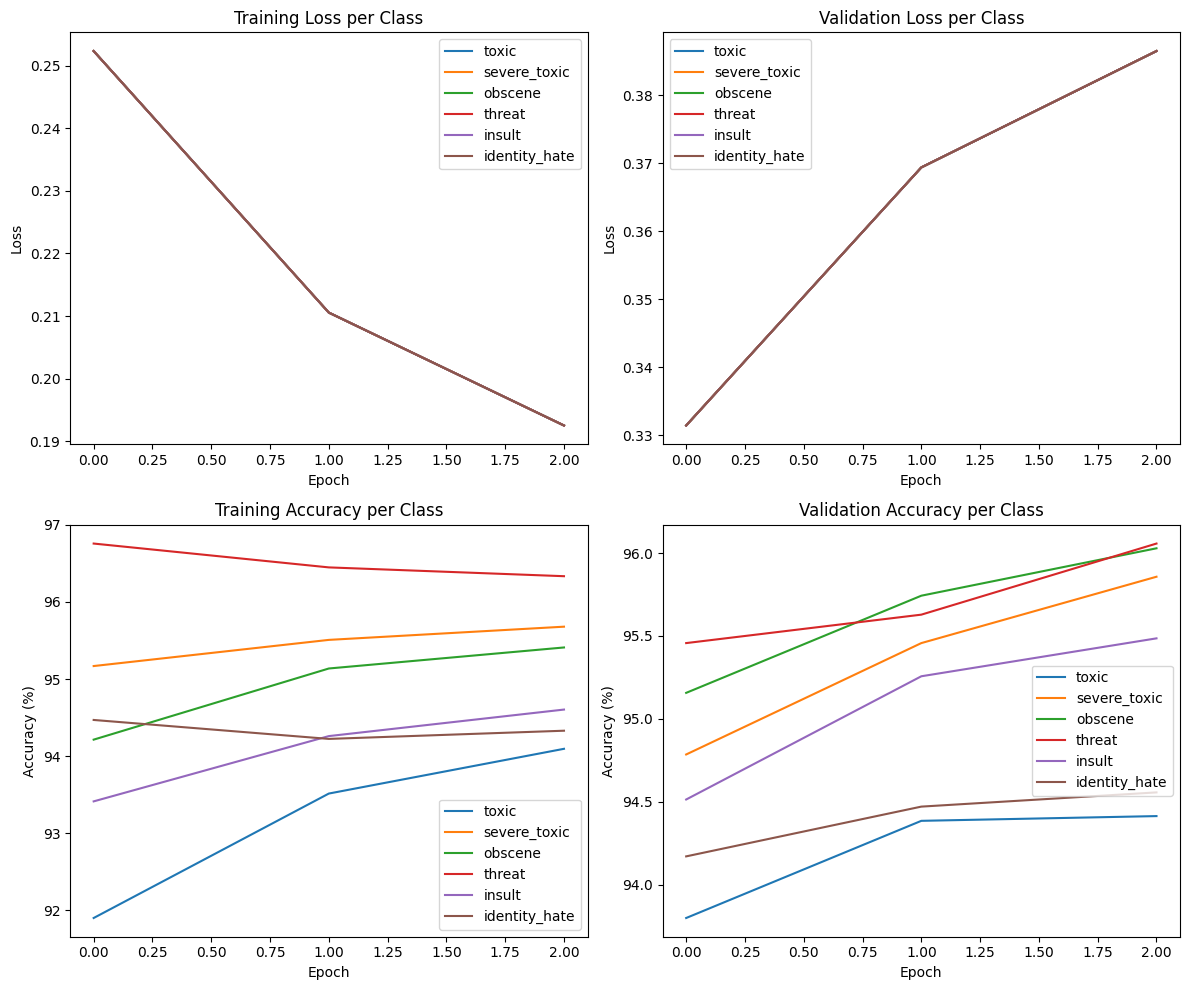

In [67]:
help_tool.plot_per_class(train_loss_per_class, val_loss_per_class,
                         train_accuracy_per_class, val_accuracy_per_class)

Having weighted BCE shows promise, as prior models showed almost 100% accuracy due to threats (small case count), but this instance is showing lower values - the model is predicting this class.

In [68]:
torch.save(model.state_dict(), 'model_AdamW_WeightedBCELoss_per_class')

## Optimizing threshold value for F1 score 
Best theshold is 0.95. F1 score is slightly better than non weighted BCE, but very similar.

In [69]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(
    model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.95
F1:  0.70
Accuracy:  0.92 

               precision    recall  f1-score   support

        toxic       0.87      0.63      0.73       669
 severe_toxic       0.61      0.16      0.26        67
      obscene       0.79      0.74      0.77       371
       threat       0.00      0.00      0.00        21
       insult       0.71      0.70      0.71       345
identity_hate       0.00      0.00      0.00        61

    micro avg       0.80      0.62      0.70      1534
    macro avg       0.50      0.37      0.41      1534
 weighted avg       0.76      0.62      0.68      1534
  samples avg       0.05      0.05      0.05      1534



## Test data
Test data shows F1 for severe_toxic at 32% (9%) increase and other categories decrease arround 10%.

In [70]:
help_tool.altered_tresshold_classification_report(
    model, device, test_dataloader, test_label_cols, 0.95)

F1:  0.62
Accuracy:  0.89 

               precision    recall  f1-score   support

        toxic       0.62      0.70      0.66      6045
 severe_toxic       0.42      0.26      0.32       365
      obscene       0.60      0.75      0.66      3668
       threat       0.00      0.00      0.00       208
       insult       0.52      0.68      0.59      3411
identity_hate       0.00      0.00      0.00       712

    micro avg       0.59      0.65      0.62     14409
    macro avg       0.36      0.40      0.37     14409
 weighted avg       0.55      0.65      0.59     14409
  samples avg       0.06      0.06      0.06     14409



## Conclusion
Weighted BCE increased minority class severe_toxic F1 by 9% (to 32%), but decreased the majority classes up to 60%.

# False guessses
Checking bad predictions in creaned data, a sentiment of aggressive or passive aggresive tone arrizes. It could be that model is picking up aggression as main sentiment of melonging to either of multiclasses.

In [90]:
help_tool.print_bad_guesses(model, test_dataloader,
                            label_cols, tokenizer, threshold=0.95)


--- Misclassifications for toxic ---

Example 1:
Text: four references including britannica giving correct date getting silly complain edit summary find ive added quotes two help youre wpsourceaccess im happy concede britannica alone mentions date offer without explaining context thats one sources ive expanded quote specifically mentioning august russian wikipedia august forces th tank corps army paulus reached volga north stalingrad cited war diary colonelgeneral franz haider

Example 2:
Text: use assisted suicide refer aid dying inaccurate fourth distinctive ways first coined catholic activists disputing oregons measure carries political bias second laws oregon washington vermont contain term assisted suicide use aid dying third assisting suicide remains illegal three states also montana new mexico state attorney general county district attorney charged physician pharmacist acted within aid dying laws three states finally describing people use aid dying brittany maynard suicides gro

# Conclusion
In this notebook, the Reboreta model was used for transfer learning. Some classes with the lowest amount of cases got no predictions from the model (threat, identity_hate). With Weighted BCE, severe_toxic got F1 up to 32%, while other categories got around 60% F1. Overall, the created model is not great, bad cases show a sentiment of aggression or passive aggression, which is an element of all toxic comments. 